# James Griffin 
## Credit Fraud Report 
## Stat 536 

##### Credit Card Fraud
Credit card fraud costs consumers an estimated $22 billion per year. Due to the importance of this issue, credit card companies typically have teams of data scientists specifically tasked with identifying fraudulent transactions. The dataset CCFraud.csv contains information on about 300,000 credit card transactions of which only 492 are known to be fraudulent (about 0.1%). The dataset also contains information on 29 different characteristics of the transaction. However, because such information is highly proprietary and confidential, most of the explanatory variables (labeled simply as V1-V28) are the principal component scores of the explanatory variables (borrowing 536 notation, these are the “Z’s” rather than the original “X’s”). Your task is to try to identify which transactions are fraudulent. The only question I really need to know is:

1. How accurately can you identify the fraudulent transactions? In other words, given a transaction is fraudulent, how well do you identify it as such?

In [53]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import warnings; warnings.simplefilter('ignore')

def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""
    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)
    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0
    minxd = np.min(xd)
    maxxd = np.max(xd)
    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept
    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha)
    #Calculate R Squared
    p = np.poly1d(coeffs)
    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot
    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr
    

In [10]:
## import data and view  
data = pd.read_csv('../data/cf2.csv')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

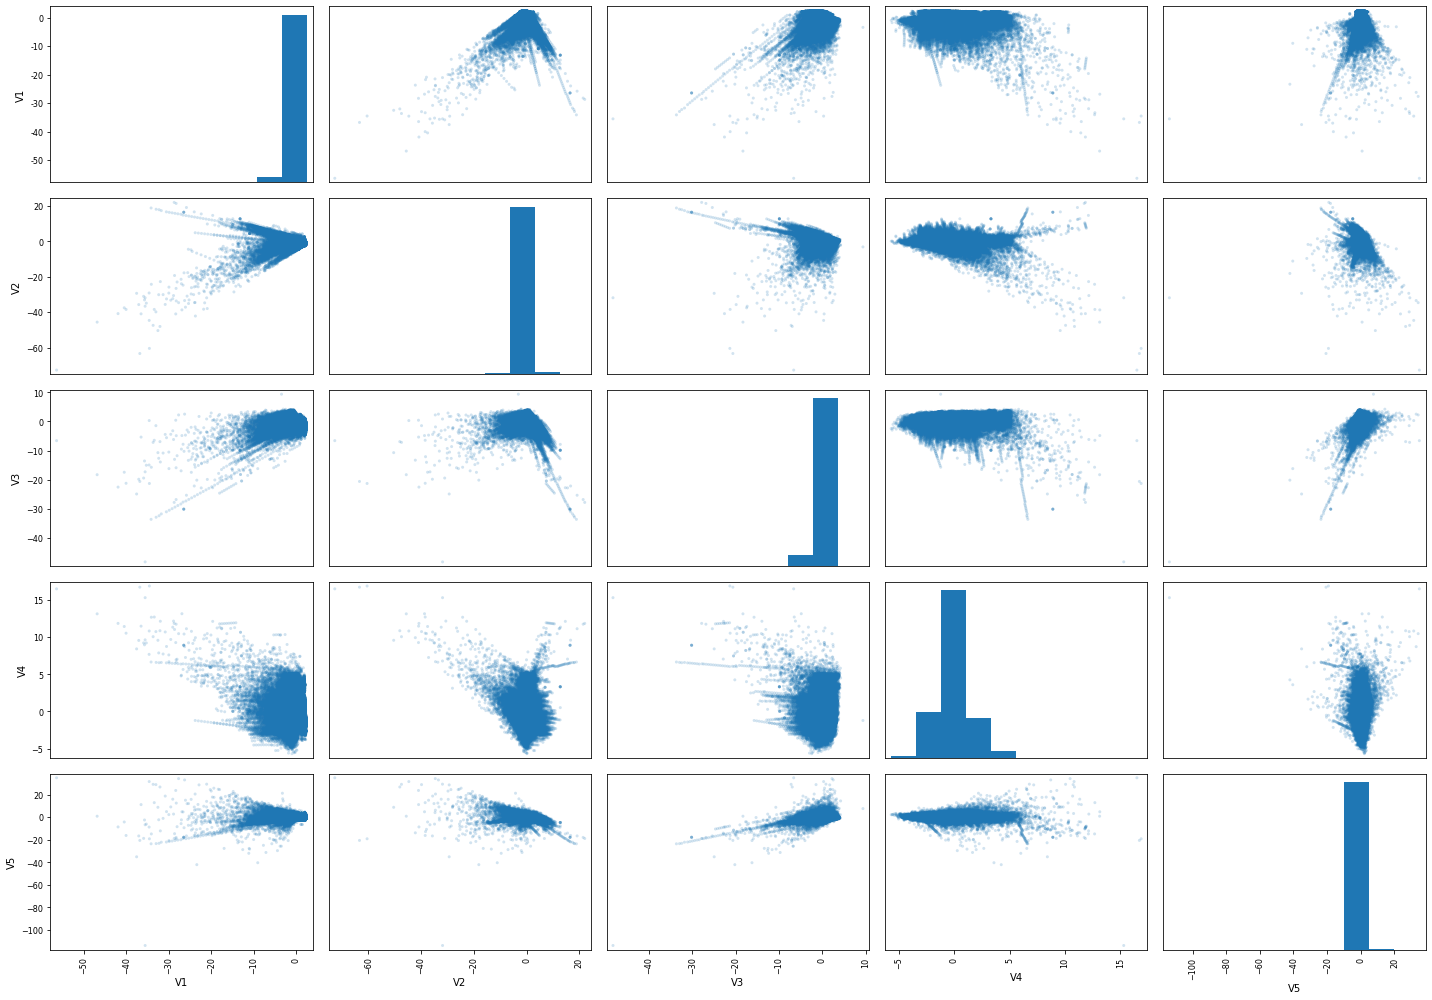

In [15]:
#ok severly under represented -- a,so  wanted to look at the histograms of my  v variables 
scatter = data[["V1", "V2", "V3",
                  "V4", "V5",]]
scatter_matrix(scatter, alpha = .2, figsize= [20, 14])
scatter_matrix
plt.tight_layout()
plt.show()

ok awesome, so it looks like my Vs or Zs orr whatever you wanan call them have been cenred and scaled, but the other variables are just kind of all over the place, clustered, no relationship at all in terms of linear or anything, but this is good, this will help us going forward 


In [94]:
y_test.Class.value_counts()

0    85288
1      155
Name: Class, dtype: int64

In [124]:
#we are going to standard scale the amount variable so that it is like the others 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
amount_scaled = scaler.fit(np.array(data.Amount).reshape([-1,1]))

scaled_amount = scaler.transform(np.array(data.Amount).reshape([-1,1]))
scaled_amount

array([[ 0.24496426],
       [-0.34247454],
       [ 1.16068593],
       ...,
       [-0.0818393 ],
       [-0.31324853],
       [ 0.51435531]])

In [125]:
data['Amount'] = scaled_amount

In [126]:
from imblearn.over_sampling import SMOTE

X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']


#os = SMOTE(sampling_strategy={1: 13000}, random_state=0)
os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=7)

columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train,)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Class'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Class']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Class']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['Class']==1])/len(os_data_X))

length of oversampled data is  398054
Number of no subscription in oversampled data 199027
Number of subscription 199027
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [127]:
#ok now that we have even classes for only our training data, we will build our two infastructures of 
#random forest and nural networks bu now we have like almost 400k ovservations so  im gonna  take a random
#random  sample of 50k to try and speed things up

os_data = os_data_X.copy()
os_data['y'] = os_data_y
os_data

m_data = os_data.sample(n=200000)

In [129]:
m_data.y.value_counts()

1    50104
0    49896
Name: y, dtype: int64

In [49]:
#============================================================================================================
def train_predict(modeling_df):
    
    target = modeling_df['y']
    #target = norm['total compensation']
    X = modeling_df.drop(columns = ['y'])
    #splitting into train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.20, 
                                                    random_state=17)

    #xclass = xgb.XGBRegressor(booster = 'dart')
    rf2 = RandomForestRegressor()

    parameters = {
        #'learning_rate': [.01, .02, .03, .04, .05], # np.arange(.01, 1, .01), #LOOK AT INCREASING STEP SIZES
        'min_samples_split': [2,4,6,8],
        'max_depth': [25, 30, 35, 37, 40, 45, 50], #np.arange(1, 100, 1), #
        #'min_child_samples': [1, 3, 5], #np.arange(1, 15, 2), #,
        'min_samples_leaf': [1, 2, 3],
        #'subsample': np.arange(.3, .7, .1),
        #'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :[700, 800, 900, 1000, 1100, 1200], #np.arange(100, 1200, 100), #
        #'objective': ['reg:squarederror'],  
        }
 
    #gs = RandomizedSearchCV(xclass, parameters, cv = 5
    #gs.fit(X_train, y_train)
    
    gs2 = RandomizedSearchCV(rf2, parameters)
    gs2.fit(X_train, y_train)
    
    #adjusting back from the log that we took 
    rf_pred2 = gs2.predict(X_test)

    mae_rf = mean_absolute_error(rf_pred2, y_test)
    print("mean_absolute_error")
    print(mae_rf)    
    print(" ")
    print("root_mean_squarered_error")
    mse_rf = (mean_squared_error(rf_pred2, y_test))**(1/2)
    print(mse_rf)

    plt.scatter(x = rf_pred2, y = y_test, color = "blue")
    plt.title("Random Forest CV = 5, base salary excluded")
    plt.xlabel('True resale_value')
    plt.ylabel("Predicted resale_value")
    trendline(rf_pred2, y_test)
    plt.show()
    
    #looking at how we did 
    #boost_preds = gs.predict(X_val)

    #mae_xgb = mean_absolute_error(np.e**(boost_preds), np.e**(y_val))
    #mse_xgb = mean_squared_error(np.e**(boost_preds), np.e**(y_val))
    #print("overall MAE")
    #print(mae_xgb)  
    #print(" ")
    #print(mse_xgb)

    #plt.scatter(x = rf_pred2, y = np.e**y_val, color = "blue")
    #plt.scatter(x = np.e**(y_val), y = np.e**(boost_preds), color = "lightgreen")
    #plt.title("xgboost CV = 5")
    #plt.xlabel('resale_value')
    #plt.ylabel("predicted_resale_value")
    #trendline(np.e**(boost_preds), np.e**(y_val))
    #plt.show()

    #X_val['predicted'] = boost_preds
    #X_val['actual'] = y_val

    y = np.sort(gs2.best_estimator_.feature_importances_)[::-1]
    x = X.columns[np.argsort(gs2.best_estimator_.feature_importances_)[::-1]]
    plt.barh(x[:10],y[:10])
    plt.tight_layout()
    plt.xlabel('Feature importance on testing')
    plt.ylabel('Feature name')
    plt.title('Feature importances in Prediction for Credit Fraud by way of Random Forest')
    plt.show() 
    
    return gs2, mse_rf, mae_rf

In [51]:
#model, mse, mae = train_predict(m_data)  # runing this on a GPU on notebook cuz taking too long here 

In [52]:

from numpy import array
from numpy import argmax
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM



In [54]:
def binary_encoding(outcome_col):

    labels = []
    for i in outcome_col:
        if i == 1:
            labels.append([1,0])
        else:
            labels.append([0,1])
    return np.array(labels)



In [130]:
len(X_train)/1000

199.364

In [131]:
m_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,y
373053,-16.378145,10.541211,-19.559237,6.137756,-12.858734,-4.075333,-14.074829,10.980036,-3.270110,-9.490472,...,1.630223,-1.255213,-0.644729,0.065360,1.038295,-0.259713,1.686727,0.519496,0.046539,1
300131,-1.796512,1.987722,-6.778081,5.357220,-2.709106,-2.070890,-5.072720,1.203855,-4.324461,-8.180945,...,1.354320,-0.683695,-0.718684,-0.359484,0.759758,1.008030,1.289442,0.803382,1.452708,1
240049,0.020089,0.403152,0.783399,2.006644,-2.245322,1.114786,-1.295518,-3.331414,0.097521,-1.121907,...,-1.758639,0.727571,0.228663,0.666878,0.560663,-0.068777,0.250248,0.192679,0.500031,1
246002,-24.393768,16.015390,-26.510527,7.971031,-16.032413,-0.844400,-29.701838,-13.028012,-9.472042,-21.566321,...,-8.933582,3.810920,1.155492,0.319006,-0.143729,-0.799200,-5.817581,-0.895114,-0.349231,1
339908,-0.748203,0.429469,0.565244,0.253170,0.452411,-1.002946,0.985137,-0.198369,-0.530865,-0.661492,...,-0.173928,-0.310685,-0.226542,0.095967,0.343958,-0.502635,-0.022193,0.011281,0.048692,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314503,-2.595020,-1.338837,1.052481,1.874029,-0.105529,-0.347977,0.828156,-0.329350,0.514454,0.197067,...,-0.325979,0.469147,0.739058,0.309608,0.215882,-0.147897,0.049394,0.318779,0.510373,1
46952,-0.603363,0.996185,1.138111,-0.110202,0.351975,-0.519032,0.583153,0.041467,-0.603399,-0.234529,...,-0.223553,-0.597355,0.069701,-0.042494,-0.113407,0.066698,0.127891,0.067032,-0.342914,0
281958,-1.859199,4.973506,-6.033675,5.745624,1.123711,-3.041571,-1.801808,0.641454,-3.801585,-7.444861,...,0.622065,-0.409073,-0.715754,-0.280226,1.100728,0.330372,0.864160,0.552912,-0.349231,1
186984,1.926480,-0.096349,-2.024053,0.023509,1.292820,1.194517,-0.169102,0.377133,0.295485,-0.339120,...,-0.265133,-0.615799,0.340295,-1.044785,-0.441462,0.279786,-0.020463,-0.055866,-0.313289,0


In [132]:
def split(df, outcome_col):
    # Split dataset in 60% train, 20% test and 20% validation
    #train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

    train_x = df.drop(columns = ["y"])
    train_y = df['y']
    
    trainy = binary_encoding(train_y)
    
    #test
    

    return train_x, trainy

hidden_nodes = int(1/1000 * (len(X_train)))
print(f"The number of hidden nodes is {hidden_nodes}.")



The number of hidden nodes is 199.


In [133]:
print("multi_class_ln")
m_data_x, m_data_y  = split(m_data,'Amount')

multi_class_ln


In [134]:
m_data_y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

In [135]:
output_labels = 2
def build(train_x, train_y,):
   # Build the model
    print('Build model...')
    
    model = Sequential()
    print(np.array(train_x))
    #model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(np.array(train_x), np.array(train_x))))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    batch_size=100
    
    model.fit(train_x, train_y, batch_size=batch_size, epochs=1000)
 
    return model 

In [136]:
model_multi = build(m_data_x, m_data_y,)

Build model...
[[-16.378145    10.54121095 -19.55923699 ...   1.68672682   0.51949615
    0.04653925]
 [ -1.79651232   1.9877222   -6.77808111 ...   1.28944231   0.80338168
    1.4527077 ]
 [  0.02008945   0.40315188   0.78339851 ...   0.25024765   0.19267939
    0.50003132]
 ...
 [ -1.85919906   4.97350635  -6.03367546 ...   0.86415984   0.55291241
   -0.34923131]
 [  1.92648002  -0.09634908  -2.02405298 ...  -0.02046343  -0.05586644
   -0.31328851]
 [ -3.72944341   4.74959884  -5.30919078 ...   0.74700133   0.54433664
   -0.15495915]]
Epoch 1/1000
1000/1000 [==============================] - 1s 929us/step - loss: 0.5421 - acc: 0.7697
Epoch 2/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1959 - acc: 0.9302A: 2s - los
Epoch 3/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1785 - acc: 0.9320
Epoch 4/1000
1000/1000 [==============================] - 1s 896us/step - loss: 0.1773 - acc: 0.9310
Epoch 5/1000
1000/1000 [======================

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1736 - acc: 0.9326
Epoch 76/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1759 - acc: 0.9306
Epoch 77/1000
1000/1000 [==============================] - 1s 970us/step - loss: 0.1753 - acc: 0.9310
Epoch 78/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1716 - acc: 0.9334
Epoch 79/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1736 - acc: 0.9325
Epoch 80/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1758 - acc: 0.9312
Epoch 81/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1732 - acc: 0.9333
Epoch 82/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1744 - acc: 0.9309
Epoch 83/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1740 - acc: 0.9322
Epoch 84/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1782 - acc: 0.9299
Epoch 85/100

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1739 - acc: 0.9319A: 1s - loss
Epoch 155/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1740 - acc: 0.9319
Epoch 156/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1754 - acc: 0.9318
Epoch 157/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1754 - acc: 0.9314A: 0s - loss: 0.1756 - acc: 
Epoch 158/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1740 - acc: 0.9322A: 0s - loss: 0.1739 - acc: 
Epoch 159/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1733 - acc: 0.9317
Epoch 160/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1746 - acc: 0.9314 - ETA: 1s - loss: 0.1748
Epoch 161/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1741 - acc: 0.9317
Epoch 162/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1743 - acc: 0.9318
Epoch 163/100

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1741 - acc: 0.9319
Epoch 233/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1751 - acc: 0.9317
Epoch 234/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1735 - acc: 0.9324
Epoch 235/1000
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1715 - acc: 0.9320
Epoch 236/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1756 - acc: 0.9322
Epoch 237/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1776 - acc: 0.9299A: 0s - 
Epoch 238/1000
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1732 - acc: 0.9329
Epoch 239/1000
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1772 - acc: 0.9307
Epoch 240/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1739 - acc: 0.9320
Epoch 241/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1720 - acc: 0.93

Epoch 310/1000
1000/1000 [==============================] - 1s 993us/step - loss: 0.1772 - acc: 0.9305
Epoch 311/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1744 - acc: 0.9317
Epoch 312/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1765 - acc: 0.9306
Epoch 313/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1781 - acc: 0.9297
Epoch 314/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1728 - acc: 0.9330
Epoch 315/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1735 - acc: 0.9321
Epoch 316/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1742 - acc: 0.9310
Epoch 317/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 0.1732 - acc: 0.9316
Epoch 318/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1735 - acc: 0.9324A: 1
Epoch 319/1000
1000/1000 [==============================] - 3s 3ms/step - loss: 0.176

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1755 - acc: 0.9322A: 0s - loss: 0.1755 - acc: 0.93
Epoch 389/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1729 - acc: 0.9323
Epoch 390/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1733 - acc: 0.9321
Epoch 391/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1740 - acc: 0.9332
Epoch 392/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1741 - acc: 0.9314
Epoch 393/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1762 - acc: 0.9311
Epoch 394/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1707 - acc: 0.9333
Epoch 395/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1756 - acc: 0.9307
Epoch 396/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1725 - acc: 0.9324
Epoch 397/1000
1000/1000 [==============================] - 1s 1ms/step - 

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1737 - acc: 0.9322A: 0s - loss: 0.1736 - acc - ETA: 0s - loss: 0.1737 - acc: 0
Epoch 467/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1727 - acc: 0.9325
Epoch 468/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1754 - acc: 0.9315
Epoch 469/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1777 - acc: 0.9304A: 0s - loss: 0.1791 - acc:
Epoch 470/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1714 - acc: 0.9339A: 0s - loss: 0.1
Epoch 471/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1754 - acc: 0.9318A: 0s - loss: 0.1754 - acc: 0.93
Epoch 472/1000
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1700 - acc: 0.9335
Epoch 473/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1777 - acc: 0.9295
Epoch 474/1000
1000/1000 [==============================] - 1s 1ms/step

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1792 - acc: 0.9292
Epoch 544/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1757 - acc: 0.9312
Epoch 545/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1744 - acc: 0.9319
Epoch 546/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1762 - acc: 0.9310
Epoch 547/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1745 - acc: 0.9311A: 0s - loss: 0.1763 -
Epoch 548/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1752 - acc: 0.9316
Epoch 549/1000
1000/1000 [==============================] - 1s 938us/step - loss: 0.1763 - acc: 0.9299
Epoch 550/1000
1000/1000 [==============================] - 1s 925us/step - loss: 0.1740 - acc: 0.9321
Epoch 551/1000
1000/1000 [==============================] - 1s 891us/step - loss: 0.1763 - acc: 0.9309
Epoch 552/1000
1000/1000 [==============================] - 1s 911us/step - lo

1000/1000 [==============================] - 1s 919us/step - loss: 0.1758 - acc: 0.9311
Epoch 621/1000
1000/1000 [==============================] - 1s 928us/step - loss: 0.1748 - acc: 0.9311 0s - loss: 0.1751 - acc
Epoch 622/1000
1000/1000 [==============================] - 1s 982us/step - loss: 0.1746 - acc: 0.9309
Epoch 623/1000
1000/1000 [==============================] - 1s 989us/step - loss: 0.1753 - acc: 0.9321
Epoch 624/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1735 - acc: 0.9331
Epoch 625/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1725 - acc: 0.9325
Epoch 626/1000
1000/1000 [==============================] - 1s 998us/step - loss: 0.1733 - acc: 0.9320
Epoch 627/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1749 - acc: 0.9323
Epoch 628/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1742 - acc: 0.9315
Epoch 629/1000
1000/1000 [==============================] - 1s 951us/ste

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1725 - acc: 0.9326
Epoch 699/1000
1000/1000 [==============================] - 1s 968us/step - loss: 0.1713 - acc: 0.9330
Epoch 700/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1763 - acc: 0.9313
Epoch 701/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1765 - acc: 0.9323
Epoch 702/1000
1000/1000 [==============================] - 1s 976us/step - loss: 0.1743 - acc: 0.9313
Epoch 703/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1764 - acc: 0.9305
Epoch 704/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1760 - acc: 0.9314
Epoch 705/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1751 - acc: 0.9314
Epoch 706/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1729 - acc: 0.9320
Epoch 707/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1732 - acc: 0.9317
E

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1742 - acc: 0.9312
Epoch 777/1000
1000/1000 [==============================] - 1s 963us/step - loss: 0.1747 - acc: 0.9313
Epoch 778/1000
1000/1000 [==============================] - 1s 936us/step - loss: 0.1735 - acc: 0.9317
Epoch 779/1000
1000/1000 [==============================] - 1s 897us/step - loss: 0.1764 - acc: 0.9322
Epoch 780/1000
1000/1000 [==============================] - 1s 949us/step - loss: 0.1750 - acc: 0.9312
Epoch 781/1000
1000/1000 [==============================] - 1s 942us/step - loss: 0.1755 - acc: 0.9329
Epoch 782/1000
1000/1000 [==============================] - 1s 938us/step - loss: 0.1751 - acc: 0.9311
Epoch 783/1000
1000/1000 [==============================] - 1s 945us/step - loss: 0.1739 - acc: 0.9323
Epoch 784/1000
1000/1000 [==============================] - 1s 949us/step - loss: 0.1754 - acc: 0.9317
Epoch 785/1000
1000/1000 [==============================] - 1s 936us/step - loss: 0.1774 -

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1774 - acc: 0.9302A: 0s - loss: 0.1777 - acc:
Epoch 855/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1719 - acc: 0.9339
Epoch 856/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1780 - acc: 0.9300
Epoch 857/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1770 - acc: 0.9310
Epoch 858/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1743 - acc: 0.9325
Epoch 859/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1716 - acc: 0.9325
Epoch 860/1000
1000/1000 [==============================] - 1s 919us/step - loss: 0.1751 - acc: 0.9317
Epoch 861/1000
1000/1000 [==============================] - 1s 918us/step - loss: 0.1772 - acc: 0.9300
Epoch 862/1000
1000/1000 [==============================] - 1s 903us/step - loss: 0.1725 - acc: 0.9324
Epoch 863/1000
1000/1000 [==============================] - 1s 907us/step

1000/1000 [==============================] - 1s 1ms/step - loss: 0.1741 - acc: 0.9324
Epoch 934/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1739 - acc: 0.9325A: 0s - loss: 0.1729 - a
Epoch 935/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1758 - acc: 0.9326
Epoch 936/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1739 - acc: 0.9323
Epoch 937/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1721 - acc: 0.9328
Epoch 938/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1768 - acc: 0.9319
Epoch 939/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1731 - acc: 0.9327
Epoch 940/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1749 - acc: 0.9317
Epoch 941/1000
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1723 - acc: 0.9327A: 0s - loss: 0.1722 - acc: 0.
Epoch 942/1000
1000/1000 [==========================

In [137]:
preds = pd.DataFrame(model_multi.predict(X_test))

In [138]:
preds.idxmin(axis = 1)

0        0
1        0
2        0
3        0
4        0
        ..
85438    0
85439    0
85440    0
85441    0
85442    0
Length: 85443, dtype: int64

In [104]:
len(preds)

85443

In [139]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(preds.idxmin(axis = 1), y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     83366
           1       0.92      0.07      0.13      2077

    accuracy                           0.98     85443
   macro avg       0.95      0.53      0.56     85443
weighted avg       0.98      0.98      0.97     85443



In [148]:
p = preds.idxmin(axis = 1)
y_test

,Class
86801,0
34867,0
151239,0
122560,0
77820,0
...,...
11519,0
21449,0
129577,0
197268,0


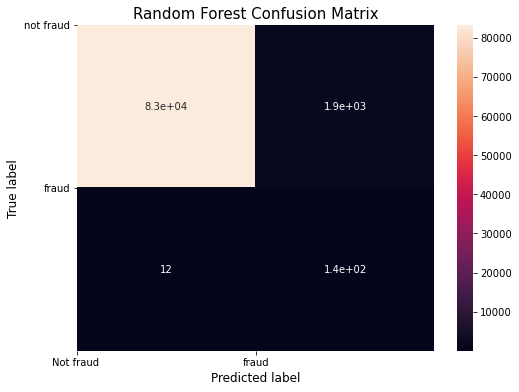

[[83354    12]
 [ 1934   143]]


In [152]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks([0, 1],
           ['Not fraud ','fraud'])
    plt.yticks([0, 1],
           ['not fraud','fraud'], rotation = 0)
    
plot_confusion_matrix(y_test, p)
plt.title("Random Forest Confusion Matrix", fontsize = 15)
plt.show()




confusion_matrix = confusion_matrix(p, y_test.Class)
print(confusion_matrix)

In [142]:
preds

,0,1
0,0.049064,0.950936
1,0.009471,0.990529
2,0.200500,0.799500
3,0.129744,0.870256
4,0.056542,0.943458
...,...,...
85438,0.048669,0.951331
85439,0.065851,0.934149
85440,0.029635,0.970365
85441,0.009209,0.990791
